# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    # cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    cifar10_dir = os.path.expanduser("~/.keras/datasets/cifar-10-batches-py")

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
def get_features(X_train, X_val, X_test, feature_fns, feature_dir="./features"):
    """get_features
    如果已经计算了 X_train, X_val, X_test 的 feature，就直接载入，不再重复计算
    """
    os.makedirs(feature_dir, exist_ok=True)

    if os.path.isfile(os.path.join(feature_dir, "X_train_feats.npy")):
        X_train_feats = np.load(os.path.join(feature_dir, "X_train_feats.npy"))
    else:
        X_train_feats = extract_features(X_train, feature_fns, verbose=True)
        np.save(os.path.join(feature_dir, "X_train_feats.npy"), X_train_feats)

    if os.path.isfile(os.path.join(feature_dir, "X_val_feats.npy")):
        X_val_feats = np.load(os.path.join(feature_dir, "X_val_feats.npy"))
    else:
        X_val_feats = extract_features(X_val, feature_fns)
        np.save(os.path.join(feature_dir, "X_val_feats.npy"), X_val_feats)
    
    if os.path.isfile(os.path.join(feature_dir, "X_test_feats.npy")):
        X_test_feats = np.load(os.path.join(feature_dir, "X_test_feats.npy"))
    else:
        X_test_feats = extract_features(X_test, feature_fns)
        np.save(os.path.join(feature_dir, "X_test_feats.npy"), X_test_feats)

    return X_train_feats, X_val_feats, X_test_feats

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
# X_train_feats = extract_features(X_train, feature_fns, verbose=True)
# X_val_feats = extract_features(X_val, feature_fns)
# X_test_feats = extract_features(X_test, feature_fns)
X_train_feats, X_val_feats, X_test_feats = get_features(X_train, X_val, X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [11]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {} # dict hparams: train_accuracy, val_accuracy
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools
# 调节超参数
experiments = itertools.product(learning_rates, regularization_strengths)
for lr, reg in experiments:
    svm = LinearSVM()
    # Learn on X_train_feats, the hog_feature and color_histogram_hsv features
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1500//3, batch_size=200, verbose=True)
    y_train_pred = svm.predict(X_train_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    print('Training accuracy: %f' % train_accuracy)
    y_val_pred = svm.predict(X_val_feats)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('Validation accuracy: %f' % val_accuracy)
    results[(lr, reg)] = train_accuracy, val_accuracy
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

  0%|          | 0/500 [00:00<?, ?it/s]training accuracy: 0.080224
validation accuracy: 0.069000
iteration 0 / 500: loss 758.423089
  1%|          | 3/500 [00:00<00:22, 21.75it/s]training accuracy: 0.097265
validation accuracy: 0.093000
iteration 0 / 500: loss 7474.156632
  1%|          | 3/500 [00:00<00:23, 21.44it/s]training accuracy: 0.094918
validation accuracy: 0.074000
iteration 0 / 500: loss 88.466966
  0%|          | 1/500 [00:00<00:58,  8.48it/s]training accuracy: 0.108061
validation accuracy: 0.100000
iteration 0 / 500: loss 769.124469
  0%|          | 0/500 [00:00<?, ?it/s]training accuracy: 0.094796
validation accuracy: 0.089000
iteration 0 / 500: loss 7956.631519
  0%|          | 2/500 [00:00<00:26, 18.70it/s]training accuracy: 0.417000
validation accuracy: 0.413000
iteration 0 / 500: loss 79.460088
  0%|          | 2/500 [00:00<00:27, 18.03it/s]training accuracy: 0.229347
validation accuracy: 0.233000
iteration 0 / 500: loss 793.294018
  1%|          | 3/500 [00:00<00:21,

In [12]:
print(results) # hparams pair (1e-08, 5000000.0) is the best, resulted in accuracies (0.417, 0.413)

{(1e-09, 50000.0): (0.08022448979591837, 0.069),
 (1e-09, 500000.0): (0.09726530612244898, 0.093),
 (1e-09, 5000000.0): (0.09491836734693877, 0.074),
 (1e-08, 50000.0): (0.10806122448979592, 0.1),
 (1e-08, 500000.0): (0.09479591836734694, 0.089),
 (1e-08, 5000000.0): (0.417, 0.413),
 (1e-07, 50000.0): (0.2293469387755102, 0.233),
 (1e-07, 500000.0): (0.40344897959183673, 0.4),
 (1e-07, 5000000.0): (0.30995918367346936, 0.321)}

In [13]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.434


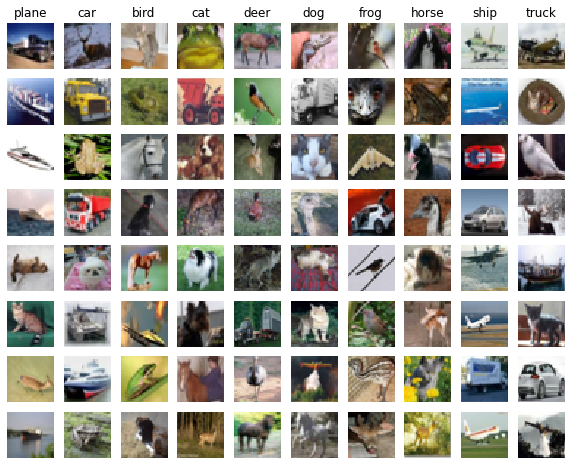

In [14]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

Somehow they make sense. The LinearSVM only takes HOG as well as color histogram as features to learn, this makes its judgement sometimes too simple. For example, as for a blue trunk on a sand road but where its above is a large piece of blue sky, the model will predict it as plane.

As for some trucks mistaken as cars, they all share the same color distribution as cars, that is, a surface with pure color and several black wheels, however, our LinearSVM ignores the differences between trucks and cars with regard to shapes, contours, edges, etc.

And there are many other phenomena, which illustrate that only HOG and color histogram features are not sufficient.


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [15]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print()

(49000, 155)
(49000, 154)


In [47]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_val = -1
best_stats = None
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results = {}
learning_rates = [0.05, 0.1] # [0.1, 0.01, 0.001]
learning_rates = [0.1]

# regularization_strengths = [0, 0.25, 0.5] # too large, not in this range
# regularization_strengths = [0, 0.05, 0.1] # too large, not in this range
# regularization_strengths = [0, 5e-3, 1e-2] # approximately in this range
regularization_strengths = [0, 5e-4, 1e-3] # best cross-validation: 0.490000
# regularization_strengths = [0, 5e-5, 1e-4] # not too many differences for 3 epochs
# regularization_strengths = [0, 5e-6, 1e-5] # not too many differences for 3 epochs
regularization_strengths = [1e-4]

# num_iters = 1500//3
epochs = 3
batch_size = 200
num_iters = epochs * X_train_feats.shape[0]//batch_size

import itertools
# 调节超参数
experiments = itertools.product(learning_rates, regularization_strengths)
for lr, reg in experiments:
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=lr, learning_rate_decay=0.95, reg=reg, num_iters=num_iters, batch_size=200, verbose=True)
    y_train_pred = net.predict(X_train_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % train_accuracy)
    y_val_pred = net.predict(X_val_feats)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % val_accuracy)
    results[(lr, reg)] = train_accuracy, val_accuracy, stats
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_stats = stats
        best_net = net

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy, stats = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


  1%|          | 9/735 [00:00<00:08, 84.95it/s]training accuracy: 0.386592
validation accuracy: 0.381000
iteration 0 / 735: loss 2.302585
100%|██████████| 735/735 [00:05<00:00, 123.54it/s]
training accuracy: 0.502571
validation accuracy: 0.484000
lr 5.000000e-02 reg 1.000000e-04 train accuracy: 0.386592 val accuracy: 0.381000
lr 1.000000e-01 reg 1.000000e-04 train accuracy: 0.502571 val accuracy: 0.484000
best validation accuracy achieved during cross-validation: 0.484000


### Debug the training

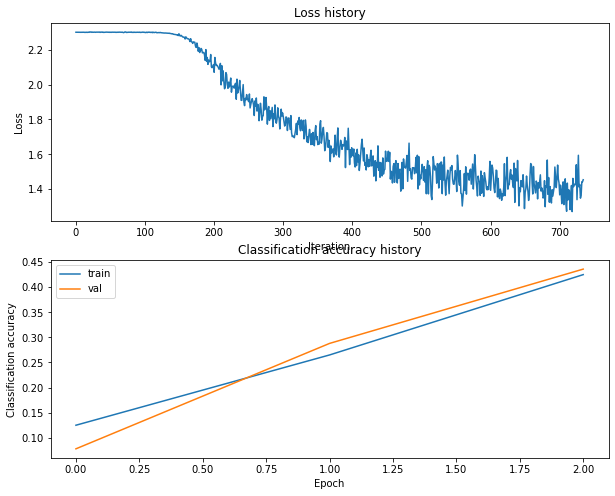

In [48]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [49]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.501


### Train for more epochs

In [50]:
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
lr, reg = 0.1, 1e-4
epochs = 10
batch_size = 200
num_iters = epochs * X_train_feats.shape[0]//batch_size
stats = net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=lr, learning_rate_decay=0.95, reg=reg, num_iters=num_iters, batch_size=200, verbose=True)

100%|██████████| 2450/2450 [00:21<00:00, 112.61it/s]


#### Finetune

In [53]:
stats1 = net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate=lr/10, learning_rate_decay=0.95, reg=reg, num_iters=num_iters, batch_size=200, verbose=True)

100%|██████████| 2450/2450 [00:21<00:00, 114.19it/s]


In [54]:
y_train_pred = net.predict(X_train_feats)
train_accuracy = np.mean(y_train == y_train_pred)
print('training accuracy: %f' % train_accuracy)
y_val_pred = net.predict(X_val_feats)
val_accuracy = np.mean(y_val == y_val_pred)
print('validation accuracy: %f' % val_accuracy)

training accuracy: 0.582347
validation accuracy: 0.556000


#### Plot final training curve

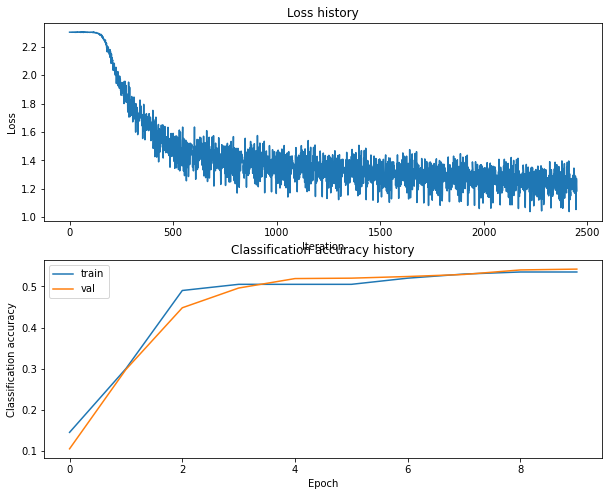

In [55]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

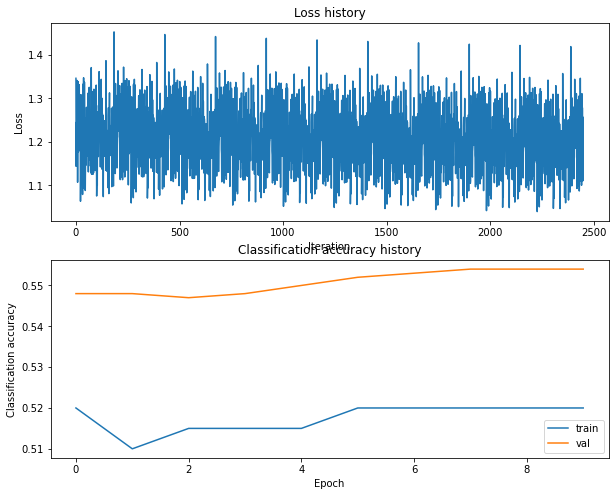

In [56]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats1['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats1['train_acc_history'], label='train')
plt.plot(stats1['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()